In [1]:
# Loading modules and pretty colours
from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
from openmmtools import integrators

import sys
sys.path.append("../saltswap/")
from mcmc_samplers import MCMCSampler
import numpy as np
import matplotlib.pyplot as plt
from pymbar import timeseries as ts
from time import time
from IPython.display import Image
%matplotlib inline
# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves.
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau4)):
    r, g, b = tableau4[i]
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

In [2]:
# Simulation parameters
mus = [-1.0, 0.0, 1.0]      # The applied (delta) chemical potentials
mus_axs = np.array(mus)

Nsamps = 200                # The number of sampling blocks
nattempts = 20              # The number of insertion/deletion attempts in a sampling block

skip = 50
# NCMC specific parameters
nprop = 1
npert = 1

# Creating the test system
size = 15.0*unit.angstrom
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
cutoff = size/2 - 0.5*unit.angstrom   # The electrostatic cutoff. Must be at least half the system size

# Pre-assigment
r_inst = np.zeros(len(mus))      # mean ratio of water to salt
r_ghmc = np.zeros(len(mus))
r_vv = np.zeros(len(mus))

rstd_inst = np.zeros(len(mus))   # standard deviation of water to salt
rstd_ghmc = np.zeros(len(mus))
rstd_vv = np.zeros(len(mus))


# Instanstaneous switching

In [3]:
t = time()
for i in range(len(mus)):
    wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i])
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.set_parampath()
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=nattempts)
        (nwats,nsalt,junk) = dummystate.saltswap.getIdentityCounts()
        ratio.append(1.0*nwats/nsalt)
    ratio = np.array(ratio)
    r_inst[i] = ratio[skip:].mean()
    try:
        stat_ineff = ts.statisticalInefficiency(ratio[skip:])
    except ts.ParameterError:
        stat_ineff = 3
    rstd_inst[i] = ratio[skip:].std()*np.sqrt(stat_ineff)
print 'Instanstaneous switching test took {0:f} seconds'.format(time() - t)

Instanstaneous switching test took 48.386331 seconds


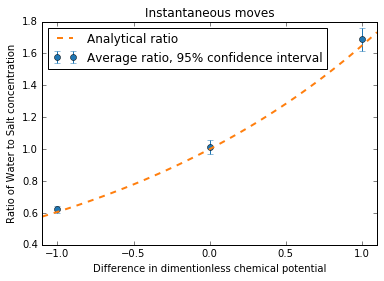

In [4]:
mus_axs = np.array(mus)
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus_axs,r_inst,yerr=2*rstd_inst/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
#plt.plot(mus,w/s,color=tableau4[1])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.title('Instantaneous moves')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()

# NCMC with GHMC

In [5]:
t = time()
for i in range(len(mus)):
    wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i],npert=npert,nprop=nprop,propagator='GHMC')
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.set_parampath()
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=nattempts)
        (nwats,nsalt,junk) = dummystate.saltswap.getIdentityCounts()
        ratio.append(1.0*nwats/nsalt)
    ratio = np.array(ratio)
    r_ghmc[i] = ratio[skip:].mean()
    try:
        stat_ineff = ts.statisticalInefficiency(ratio[skip:])
    except ts.ParameterError:
        stat_ineff = 3
    rstd_ghmc[i] = ratio[skip:].std()*np.sqrt(stat_ineff)
print 'NCMC test with GHMC took {0:f} seconds'.format(time() - t)

NCMC test with GHMC took 386.251969 seconds


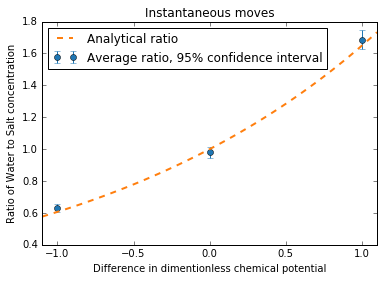

In [6]:
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus_axs,r_ghmc,yerr=2*rstd_ghmc/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
#plt.plot(mus,w/s,color=tableau4[1])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.title('Instantaneous moves')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()

# NCMC with velocity Verlet


In [7]:
size = 20.0*unit.angstrom
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
cutoff = 9*unit.angstrom   # The electrostatic cutoff. Must be at least half the system size

Nsamps = 200                # The number of sampling blocks
nattempts = 20              # The number of insertion/deletion attempts in a sampling block

In [8]:
wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
integrator = integrators.VelocityVerletIntegrator(0.5*unit.femtoseconds)
simulation = app.Simulation(wbox.topology, wbox.system, integrator)
simulation.context.setPositions(wbox.positions)
simulation.minimizeEnergy()
positions = simulation.context.getState(getPositions=True).getPositions(asNumpy=True)

In [9]:
t = time()
for i in range(len(mus)):
    wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
    dummystate = MCMCSampler(wbox.system,wbox.topology,positions,delta_chem=mus[i],npert=npert,nprop=nprop,propagator='velocityVerlet')
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.set_parampath()
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=nattempts)
        (nwats,nsalt,junk) = dummystate.saltswap.getIdentityCounts()
        ratio.append(1.0*nwats/nsalt)
    ratio = np.array(ratio)
    r_vv[i] = ratio[skip:].mean()
    try:
        stat_ineff = ts.statisticalInefficiency(ratio[skip:])
    except ts.ParameterError:
        stat_ineff = 3
    rstd_vv[i] = ratio[skip:].std()*np.sqrt(stat_ineff)
print 'NCMC test with velocity Verlet took {0:f} seconds'.format(time() - t)

NCMC test with velocity Verlet took 352.141153 seconds


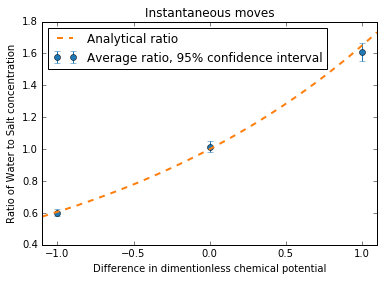

In [10]:
mus = np.array(mus)
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus,r_vv,yerr=2*rstd_vv/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
#plt.plot(mus,w/s,color=tableau4[1])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.title('Instantaneous moves')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()